Focused notebook for working with long files with the goal of generating a textfile in script format

In [1]:
import os, re
import pandas as pd
from bs4 import BeautifulSoup

import librosa.display
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import Audio, display

import torch
import whisperx

In [2]:
# Hardcoded Values
SAMPLING_RATE = 16000 # All models predict on a monochannel 16khz tensor
VAD_THRESHOLD = 0.5
audacity_dir = '../data/db_02-03-2023/'

## Models

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
model_file = '../models/whisper/small.en.pt'
silero_dir = '../models/silero-vad'

In [4]:
whisper_model = whisperx.load_model(model_file, device)

In [5]:
silero_vad, utils =    torch.hub.load(repo_or_dir=silero_dir,
                               source='local',
                               model='silero_vad',
                               force_reload=True,
                               onnx=False)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

In [6]:
align_model, metadata = whisperx.load_align_model(language_code='en', device=device)

## Functions

In [7]:
def vizualize_waveform(waveform, rate=SAMPLING_RATE):
    plt.figure(figsize=[7,2.5])
    librosa.display.waveshow(waveform, sr=rate)
    plt.show()

In [8]:
def listen_waveform(waveform, rate=SAMPLING_RATE):
    display(Audio(waveform, rate=rate))

In [9]:
def get_discord_name(filename):
    discord_name_pattern = r'.+-(.*)\..+'
    username = re.search(discord_name_pattern, filename).group(1)
    return username

In [10]:
def find_aup_file(path):
    aup_files = [f for f in os.listdir(path) if f.endswith('.aup')]
    return aup_files[0] # Assume only one file per directory

In [11]:
def parse_audacity_project(path_to_aup_file):
    
    with open(path_to_aup_file, 'r') as f:
        aup = BeautifulSoup(f, features="lxml-xml")
    
    root_path = os.path.split(path_to_aup_file)[:-1]
    root_path = os.path.join(*root_path)

    project = aup.find('project')
    proj_name = project.get('projname')
    data_path = os.path.join(root_path, proj_name)

    proj_imports = project.find_all('import')
    proj_files = []
    for item in proj_imports:
        filename, offset= item.get('filename'), float(item.get('offset'))
        entry = {
            'filename': filename,
            'offset': offset
        }
        proj_files.append(entry)

    
    output = {
        'project_name' : proj_name,
        'root_path': root_path,
        'data_path': data_path,
        'files': proj_files
    }

    return output

In [12]:
def get_segment_overlap_percent(parent: range, child: range) -> float:
    """Calculates the percentage of which the child's boundries fit within the parent's boundries."""
    olap = range(max(parent[0], child[0]), min(parent[-1], child[-1])+1)
    olap_percent = len(olap) / len(child)
    return olap_percent

In [13]:
def get_vad_data(audio):
    """Process Silero VAD on audio waveform.
    Returns:
    df, speech_only_waveform, (vad_segments, speech_only_segments)"""
    vad_segments = get_speech_timestamps(audio, silero_vad, threshold=VAD_THRESHOLD)
    speech_only_waveform = collect_chunks(vad_segments, torch.tensor(audio))
    
    speech_only_segments = []
    current_frame = 0
    for i, entry in enumerate(vad_segments):
        speech_length = entry['end'] - entry['start']
        end_frame = current_frame + speech_length
        speech_only_segments.append(
            {'start': current_frame,
            'end': end_frame
            }
            )
        current_frame = end_frame

    df = []
    for i, (orig, short) in enumerate(zip(vad_segments, speech_only_segments)):
        df.append({
            'id': i,
            'start': orig['start'],
            'end': orig['end'],
            'so_start': short['start'],
            'so_end': short['end']
        })

    df = pd.DataFrame(df)

    return df, speech_only_waveform, (vad_segments, speech_only_segments)

In [14]:
def transcribe_and_align(audio):
    results = whisper_model.transcribe(audio)
    results_aligned = whisperx.align(results["segments"], align_model, metadata, audio, device)
    df = pd.DataFrame(results_aligned['word_segments'])
    df[['start','end']] = (df[['start','end']] * SAMPLING_RATE).astype(int)
    transcription_df = df
    return transcription_df, results_aligned

In [15]:
def assign_words_to_segments(segment_df, words_df):
    segment_ranges = [range(x,y) for x,y in segment_df[['so_start','so_end']].values]
    word_ranges = [range(x,y) for x,y in words_df[['start','end']].values]

    ids = []
    last_segment_detected = 0
    for word_segment in word_ranges:
        for i, segment in enumerate(segment_ranges)[last_segment_detected:]:
            if get_segment_overlap_percent(segment, word_segment) > .5:
                last_segment_detected = i
                ids.append(i)
                break
        else:
            ids.append(None)
    words_df['parent_id'] = ids

    f = lambda x: words_df[words_df['parent_id'] == x['id']]
    segment_df['word_segments'] = segment_df.apply(f, axis=1)

    f = lambda x: ' '.join(x['word_segments']['text'].to_list())
    segment_df['text'] = segment_df.apply(f, axis=1)

    return segment_df, words_df

In [16]:
def process_audio(audio):

    df, speech_only_waveform, (vad_segments, speech_only_segments) = get_vad_data(audio)

    adf, results_aligned = transcribe_and_align(speech_only_waveform)

    df, adf = assign_words_to_segments(df, adf)
    # segment_ranges = [range(x,y) for x,y in df[['so_start','so_end']].values]
    # word_ranges = [range(x,y) for x,y in adf[['start','end']].values]

    # ids = []
    # for word_segment in word_ranges:
    #     for i, segment in enumerate(segment_ranges):
    #         if get_segment_overlap_percent(segment, word_segment) > .5:
    #             ids.append(i)
    #             break
    #     else:
    #         ids.append(None)
    # adf['parent_id'] = ids

    # f = lambda x: adf[adf['parent_id'] == x['id']]
    # df['word_segments'] = df.apply(f, axis=1)

    # f = lambda x: ' '.join(x['word_segments']['text'].to_list())
    # df['text'] = df.apply(f, axis=1)

    return df, adf

## Audacity Parsing

In [17]:
path = os.path.join(audacity_dir, find_aup_file(audacity_dir))

project = parse_audacity_project(path)
pprint(project)

{'data_path': '../data/db_02-03-2023\\V8DcTChKFF_data',
 'files': [{'filename': '1-CS12_4510.ogg', 'offset': 0.0},
           {'filename': '2-Crux_4429.ogg', 'offset': 0.0},
           {'filename': '3-JadePixie_7138.ogg', 'offset': 0.0},
           {'filename': '4-IlMaximuslI_9218.ogg', 'offset': 0.0}],
 'project_name': 'V8DcTChKFF_data',
 'root_path': '../data/db_02-03-2023'}


../data/db_02-03-2023\V8DcTChKFF_data\1-CS12_4510.ogg


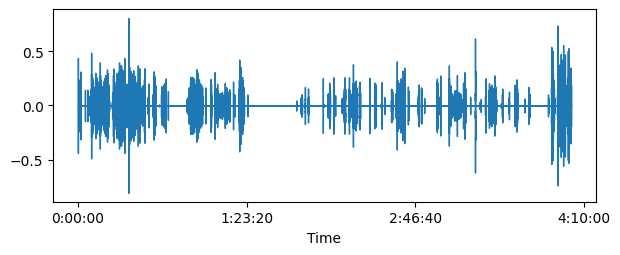

../data/db_02-03-2023\V8DcTChKFF_data\2-Crux_4429.ogg


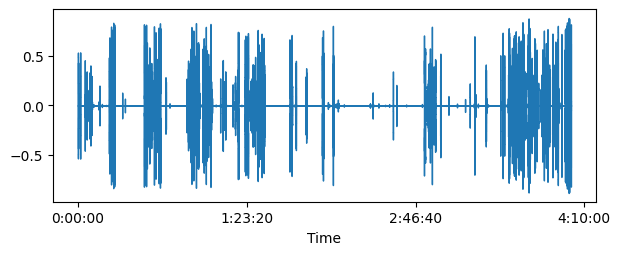

../data/db_02-03-2023\V8DcTChKFF_data\3-JadePixie_7138.ogg


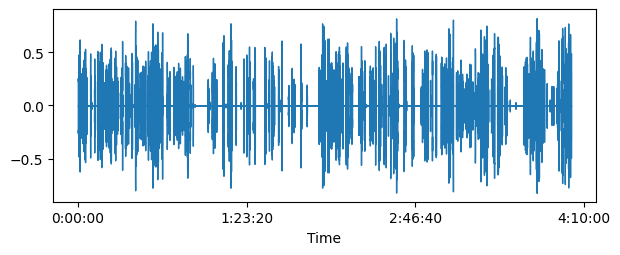

../data/db_02-03-2023\V8DcTChKFF_data\4-IlMaximuslI_9218.ogg


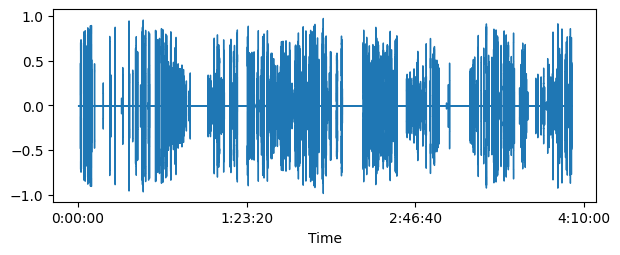

In [18]:
waveforms = []
for file in project.get('files'):
    filename = file.get('filename')
    filepath = os.path.join(project.get('data_path'), filename)
    print(filepath)
    wav = whisperx.load_audio(filepath)
    vizualize_waveform(wav)
    waveforms.append((filename, wav))

In [19]:
pprint(waveforms)

[('1-CS12_4510.ogg',
  array([0.00344849, 0.00344849, 0.003479  , ..., 0.        , 0.        ,
       0.        ], dtype=float32)),
 ('2-Crux_4429.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)),
 ('3-JadePixie_7138.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)),
 ('4-IlMaximuslI_9218.ogg',
  array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))]


## Processing Audio Files

In [20]:
# transcript_dfs = []
# for filename, waveform in waveforms:
#     df, adf = process_audio(waveform)
#     out = {
#         'speaker': get_discord_name(filename),
#         'filename': filename,
#         'full': df,
#         'words': adf
#     }
#     transcript_dfs.append(out)

In [21]:
# import pickle

# with open('./cache/transcript_dfs.pickle', 'wb') as f:
#     pickle.dump(transcript_dfs, f)

### One at a time

In [22]:
waveforms

[('1-CS12_4510.ogg',
  array([0.00344849, 0.00344849, 0.003479  , ..., 0.        , 0.        ,
         0.        ], dtype=float32)),
 ('2-Crux_4429.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)),
 ('3-JadePixie_7138.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)),
 ('4-IlMaximuslI_9218.ogg',
  array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))]

In [23]:
filename, waveform = waveforms[2]
print(filename)
print(waveform)

3-JadePixie_7138.ogg
[0. 0. 0. ... 0. 0. 0.]


In [24]:
segment_df, speech_only_waveform, (vad_segments, speech_only_segments) = get_vad_data(waveform)

c:\Python\3.10.8\lib\site-packages\torch\nn\modules\module.py:1194: UserWarning: operator () profile_node %668 : int[] = prim::profile_ivalue(%666)
 does not have profile information (Triggered internally at ..\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return forward_call(*input, **kwargs)


In [25]:
segment_df.head(), segment_df.shape

(   id   start     end  so_start  so_end
 0   0   30752   91616         0   60864
 1   1  151072  201184     60864  110976
 2   2  210464  216544    110976  117056
 3   3  276000  319968    117056  161024
 4   4  325664  351712    161024  187072,
 (1323, 5))

In [26]:
## This was taking much longer than expected.

# transcription_df, results_aligned = transcribe_and_align(speech_only_waveform)
# transcription_df.shape

In [27]:
# Audio(speech_only_waveform, rate=SAMPLING_RATE)

In [31]:
speech_only_waveform.numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [32]:
results = whisper_model.transcribe(speech_only_waveform.numpy())

KeyboardInterrupt: 